In [1]:
import glob
import os
from matplotlib import image as img
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np
import scipy.ndimage as ndi
import seaborn as sns
from cycler import cycler

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['font.size'] = 18
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.family'] = 'Times New Roman'


In [3]:
#Functions

# Generate images:
def get_images(image_folder_path, remove_idx_list, correction_xyd):
    "Returns raw images and corrected images."
    # Get paths:
    image_path_list = glob.glob(image_folder_path)
    image_path_list = np.delete(image_path_list, remove_idx_list)

    # Get images:
    raw_image_array = []
    corrected_image_array = []
    for path in image_path_list:
        image = img.imread(path)
        correction = ndi.mean(image[correction_xyd[1]:correction_xyd[1]+correction_xyd[2],correction_xyd[0]:correction_xyd[0]+correction_xyd[2]])
        raw_image_array.append(image) 
        corrected_image_array.append(image-correction)
    raw_image_array = np.array(raw_image_array) 
    corrected_image_array = np.array(corrected_image_array) 
     
    return raw_image_array, corrected_image_array

def crop_and_join_images(image_array, mask, adjust=0):
    pad = 2
    images = [image_array[:,mask_corners[2]:mask_corners[3], mask_corners[0]:mask_corners[1]] for mask_corners in mask]
    thickness, heights, widths = zip(*(i.shape for i in images))
    thickness, full_height, full_width = min(thickness), 2*max(heights)+pad, 2*max(widths)+pad

    new_array = np.ones(shape=(thickness, full_height, full_width))*(np.max([np.max(i) for i in images])-adjust)
    new_array[:, 0:heights[0], 0:widths[0]] = images[0]
    new_array[:, 0:heights[1], full_width-widths[1]-1:-1] = images[1]
    new_array[:, full_height-heights[2]-1:-1, 0:widths[2]] = images[2]
    new_array[:, full_height-heights[3]-1:-1, full_width-widths[3]-1:-1] = images[3]
    return new_array

def crop_and_join_images_mod(image_array, mask):
    pad = 2
    images = [image_array[:,mask_corners[2]:mask_corners[3], mask_corners[0]:mask_corners[1]] for mask_corners in mask[2:]]
    thickness, heights, widths = zip(*(i.shape for i in images))
    thickness, full_height, full_width = min(thickness), max(heights), 2*max(widths)+pad

    new_array = np.ones(shape=(thickness, full_height, full_width))*(np.max([np.max(i) for i in images]))
    new_array[:, :, 0:widths[0]] = images[0]
    new_array[:, :, full_width-widths[1]-1:-1] = images[1]
    return new_array

# Make Gifs and png:
def make_gifs(image_array, gif_interval, plot_path, extra_path = "", save_bool= False):
    def update(i):
        im.set_array(image_array[i])
        return im, 

    fig, ax = plt.subplots()
    shape = image_array[0].shape
    inches = 9.5
    fig.set_size_inches(inches*shape[1]/np.min(shape),inches*shape[0]/np.min(shape))
    ax.set_axis_off()
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

    vmin, vmax = np.min(image_array), np.max(image_array)
    im = ax.imshow(image_array[0], cmap='Greys_r', animated=True, vmin=vmin, vmax=vmax) 
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=gif_interval, blit=True, repeat_delay=10,)
    if save_bool:
        animation_fig.save(plot_path + "Gif" + extra_path + ".gif")
        plt.close(fig)
    else:
        plt.show()
    return
    
def make_4_gifs(image_array, gif_interval, plot_path, mask, extra_path="", save_bool=False):
    corners = ['TL', 'TR', 'BL', 'BR']
    for id, mask_corners in enumerate(mask):
        cropped_image_array = image_array[:,mask_corners[2]:mask_corners[3], mask_corners[0]:mask_corners[1]]
        make_gifs(cropped_image_array, gif_interval, plot_path, f' {corners[id]}' + extra_path, save_bool)


def show_correction_box(image_array, correction_xyd, rows, cols, plot_path, extra_path = "", save_bool = False):
    "Plot the correction boxes to check for contaminations."
    fig, axs = plt.subplots(rows,cols,constrained_layout=True)
    inches = 9.5
    inches_factor = inches/np.max((rows,cols))
    fig.set_size_inches(cols*inches_factor,rows*inches_factor)
    axs = axs.flatten()
    for i in range(rows*cols):
        if i < len(image_array):
            axs[i].imshow(image_array[i], cmap='Greys_r') 
            axs[i].text(correction_xyd[0]+5, correction_xyd[1]+10, r"$t=$"+str(i))
        axs[i].set_xlim(correction_xyd[0], correction_xyd[0]+correction_xyd[2]) 
        axs[i].set_ylim(correction_xyd[1]+correction_xyd[2], correction_xyd[1])
        axs[i].set_axis_off()
    if save_bool:
        fig.savefig(plot_path + "Correction_box_images" + extra_path + ".png")
        plt.close(fig)
    else:
        plt.show()
    return

def show_images_cropped(image_array, rows, cols, images_dict, annotate, plot_path, extra_path = "", save_bool = False, vmin=None, vmax=None):
    "Plot the images cropped by mask."
    h,w = image_array[0].shape
    fig, axs = plt.subplots(rows,cols,constrained_layout=True)
    inches = 2.5
    fig.set_size_inches(inches*cols, inches*rows)
    axs = axs.flatten()
    if vmin==None:
        vmin = np.min(image_array)
    if vmax==None:
        vmax = np.max(image_array)
    text = "$t\,=\,$"
    if rows*cols-1 < len(image_array):
        image_array = image_array[0:rows*cols-1]
    N = len(image_array)
    for i in range(rows*cols):
        if i < N:
            axs[i].imshow(image_array[i], cmap='Greys_r', vmin=vmin, vmax=vmax) 
            if i in annotate:
                text = annotate[i]
            axs[i].text(w/2,h/37,text+str(i), color=images_dict["text_color"], bbox=dict(facecolor=images_dict["bbox_facecolor"], edgecolor=images_dict["bbox_edgecolor"], pad=images_dict["bbox_pad"], alpha= images_dict["bbox_alpha"]), ha='center', va='center')
        axs[i].set_axis_off()  
    axs[N].imshow(np.zeros((h,w), dtype=np.float16), cmap='Greys')
    axs[N].text(w/2,h/2.8, images_dict["scalebar_text"], c = "black", ha='center', va='center') 
    axs[N].add_patch(Rectangle(((w-images_dict["scalebar_w"])/2, (h-images_dict["scalebar_h"])/2), images_dict["scalebar_w"], images_dict["scalebar_h"], edgecolor="black", facecolor="black"))    
          
    if save_bool:
        fig.savefig(plot_path + "Images" + extra_path + ".png", dpi=1000)
        plt.close(fig)
    else:
        plt.show()
    return

def show_hyst_cropped(image_array, rows, cols, images_dict, annotate, plot_path, extra_path = "", save_bool = False):
    "Plot the images cropped by mask."
    h,w = image_array[0].shape
    fig, axs = plt.subplots(rows,cols,constrained_layout=True)
    inches = 2.5
    fig.set_size_inches(inches*cols, inches*rows)
    axs = axs.flatten()
    vmin, vmax = np.min(image_array), np.max(image_array)
    for i in range(rows*cols):
        if i < len(annotate):
            axs[i].imshow(image_array[annotate[i]], cmap='Greys_r', vmin=vmin, vmax=vmax)
            axs[i].text(w/2,h/37,"$t\,=\,$"+str(annotate[i]), color=images_dict["text_color"], bbox=dict(facecolor=images_dict["bbox_facecolor"], edgecolor=images_dict["bbox_edgecolor"], pad=images_dict["bbox_pad"], alpha= images_dict["bbox_alpha"]), ha='center', va='center') 
        if i == len(annotate):
            axs[i].imshow(np.zeros((h,w), dtype=np.float16), cmap='Greys')
            axs[i].text(w/2,h/2.8, images_dict["scalebar_text"], c = "black", ha='center', va='center') 
            axs[i].add_patch(Rectangle(((w-images_dict["scalebar_w"])/2, (h-images_dict["scalebar_h"])/2), images_dict["scalebar_w"], images_dict["scalebar_h"], edgecolor="black", facecolor="black"))    
        axs[i].set_axis_off()   
    
    if save_bool:
        fig.savefig(plot_path + "Hyst images" + extra_path + ".png", dpi=1000)
        plt.close(fig)
    else:
        plt.show()
    return


def show_image_dist_multi(image_array_array, image_idx, plot_path, extra_path = "", save_bool = False, half=False):
    "Distribution of domain growth over many runs. Must be same image sizes!"
    N, M , h, w = image_array_array.shape
    summed_array = sum(image_array_array)/N
    summed_array = summed_array.reshape(1, *summed_array.shape)
    image_array_array = np.concatenate([image_array_array, summed_array], axis=0).reshape(M*(N+1),h, w)
    N += 1

    fig, axs = plt.subplots(N,M,constrained_layout=True)
    inches = 1.7 #2.5
    if half:
        fig.set_size_inches(inches*M + 0.4, inches*N/2.0)
    else:
        fig.set_size_inches(inches*M + 0.4, inches*N)
    axs = axs.flatten()
    vmin, vmax = np.min(image_array_array), np.max(image_array_array)
    for i in range(N*M):
        axs[i].imshow(image_array_array[i], cmap='Greys_r', vmin=vmin, vmax=vmax) 
        if i < M:
            if half:
                axs[i].text(w/2, -h/18-10,"$t\,=\,$"+str(image_idx[i]), ha='center', va='center')
            else:
                axs[i].text(w/2, -h/18,"$t\,=\,$"+str(image_idx[i]), ha='center', va='center')
        if i == M*(N-1):
            axs[i].text(-w/5-10, h/2,"Mean", ha='center', va='center')
        elif i%M==0:
            axs[i].text(-w/5-10, h/2,"Run "+str(int(i/M)), ha='center', va='center')
        axs[i].set_axis_off()   

    if save_bool:
        fig.savefig(plot_path + "Image_dist" + extra_path + ".png", dpi=400)
        plt.close(fig)
    else:
        plt.show()
    return

def show_image_dist_multi_mod1(image_array_array, image_idx, plot_path, extra_path = "", save_bool = False):
    "Distribution of domain growth over many runs. Must be same image sizes!"
    N, M , h, w = image_array_array.shape
    summed_array = sum(image_array_array)/N
    summed_array = summed_array.reshape(1, *summed_array.shape)
    image_array_array = image_array_array[0:5]
    image_array_array = np.concatenate([image_array_array, summed_array], axis=0).reshape(M*(N+1-5),h, w)
    N += 1-5

    fig, axs = plt.subplots(N,M,constrained_layout=True)
    inches = 1.7 #2.5
    fig.set_size_inches(inches*M + 0.4, inches*N)
    axs = axs.flatten()
    vmin, vmax = np.min(image_array_array), np.max(image_array_array)
    for i in range(N*M):
        axs[i].imshow(image_array_array[i], cmap='Greys_r', vmin=vmin, vmax=vmax) 
        if i < M:
            axs[i].text(w/2, -h/18-5,"$t\,=\,$"+str(image_idx[i]), ha='center', va='center')
        if i == M*(N-1):
            axs[i].text(-w/5-10, h/2,"Mean", ha='center', va='center')
        elif i%M==0:
            axs[i].text(-w/5-10, h/2,"Run "+str(int(i/M)), ha='center', va='center')
        axs[i].set_axis_off()   

    if save_bool:
        fig.savefig(plot_path + "Image_dist" + extra_path + ".png", dpi=400)
        plt.close(fig)
    else:
        plt.show()
    return

def show_image_compare_multi(image_array_list, image_idx, names, plot_path, extra_path = "", save_bool = False):
    "Distribution of domain growth in many runs."
    N, M , w, h= len(image_array_list), len(image_array_list[0]), *image_array_list[0][0].shape
    fig, axs = plt.subplots(N,M,constrained_layout=True)
    inches = 2.5
    fig.set_size_inches(inches*M + 0.6, inches*N)
    vmin, vmax = np.inf, -np.inf
    for i in range(N):
        vmin = np.min([np.min(image_array_list[i]), vmin])
        vmax = np.max([np.max(image_array_list[i]), vmax])
    for i in range(N):
        for j in range(M):
            axs[i][j].imshow(image_array_list[i][j], cmap='Greys_r', vmin=vmin, vmax=vmax) 
            if i == 0:
                axs[i][j].text(w/2, -h/18,"$t\,=\,$"+str(image_idx[j]), ha='center', va='center')
            if j==0:
                axs[i][j].text(-w/5, h/2,names[i], ha='center', va='center')
            axs[i][j].set_axis_off() 

    if save_bool:
        fig.savefig(plot_path + "Image_compare" + extra_path + ".png", dpi=1000)
        plt.close(fig)
    else:
        plt.show()
    return


# Info for each run:
def get_info(date,case,run_num):
    """
    0: image_folder_path \n
    1: data_path \n
    2: plot_path \n
    3: mask \n
    4: gif_interval \n
    5: mask_min_max_idx_list \n
    6: correction_xyd \n
    7: rows \n
    8: cols \n
    9: plot_dict \n
    10: annotate \n
    """
    
    project_folder = 'C:/Users/eivhe/OneDrive/NTNU/Prosjekt- og masteroppgave/'
    image_folder_path = project_folder + 'Measurements/'
    data_path = project_folder + 'Python/Data/'
    plot_path = project_folder + 'Python/Plots/'
    
    palette_tab10 = sns.color_palette('colorblind', 10) 

    plot_dict = {"images_dict": {"scalebar_h": 12, "scalebar_w": 87, "scalebar_text": "$10\,\mathrm{\mu m}$",
                "text_color": "w", "bbox_facecolor": 'gray', "bbox_edgecolor": 'none', "bbox_pad": 0.5, "bbox_alpha": 0.85}, 
                
                "intensity_dict": {"grid_axis": 'both', "grid_color": "grey", "grid_linestyle": "--", "grid_linewidth": "0.25", 
                "legend_loc": 'center left', "legend_bbox_to_anchor": (0.9, 0.6), "text_font_size": 12.5, "line_width": 0.8}, #12.5

                "colors": {"b":palette_tab10[0],"brown":palette_tab10[5], "i":palette_tab10[9], "r":palette_tab10[3], "black": 'black', "g":palette_tab10[2], "purple":palette_tab10[4], "gray":palette_tab10[7], "y":palette_tab10[8], "p":palette_tab10[6], "o":palette_tab10[1]},
                
                "markers": ["s", "D", "P", "X", "*", "o", "v", "^", "<", ">"]
                } 
    # 433 pix = 50 um

    if date == 4:      
        date_path = '24.04.04_IB2403.1/'
        correction_xyd = [340,40,100]
        if case == 7.7:
            if run_num in [158,180,202]:
                return
                name = date_path + f'{case}/Hyst {run_num}deg'
                remove_idx_list = [-1]
                gif_interval = 500
                rows, cols = 4, 4
                annotate = [55,56,57,58,120,121,122,123]
            elif run_num==5:
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 5, 4
                annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[240, 348, 172, 280],[435, 543, 172, 280],[240, 348, 366, 474],[435, 543, 366, 474]]
        elif case == 7.3:
            correction_xyd = [410,40,100]
            if run_num in [158,180,202]:
                return
                name = date_path + f'{case}/Hyst {run_num}deg'
                remove_idx_list = [-1]
                gif_interval = 500
                rows, cols = 4, 4
                annotate = [55,56,57,58,120,121,122,123]
            elif run_num==5:
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 5, 4
                annotate = {0: "AB, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[208, 316, 171, 278],[403, 511, 171, 278],[208, 316, 366, 473],[403, 511, 366, 473]]
        elif case == 6.7:
            correction_xyd = [340,40,100]
            if run_num in [158,180,202]:
                name = date_path + f'{case}/Hyst {run_num}deg'
                remove_idx_list = [-1]
                gif_interval = 500
                rows, cols = 4, 4
                annotate = [55,56,57,58,120,121,122,123]
            else:   print("Run doesn't exist!"); return
            mask = [[256, 363, 179, 283],[447, 555, 179, 283],[256, 363, 376, 479],[447, 555, 376, 479]]
       
       
        else:
            print("Case doesn't exist!"); return
    
    elif date == 29:   
        date_path = '24.04.29_IB2403.1/'
        correction_xyd = [340,40,100]
        if case == 6.5:
            if run_num not in range(0,5): print("Run doesn't exist!"); return   
            name = date_path + f'{case}/Run {run_num}'
            remove_idx_list = [0,1]
            mask = [[244, 352, 176, 284],[440, 547, 176, 284],[244, 352, 371, 479],[440, 547, 371, 479]]
            gif_interval = 500
            rows, cols = 4, 4 
            annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$"} 
        elif case == 6.6:
            if run_num in [158,180,202]:
                name = date_path + f'{case}/Hyst {run_num}deg'
                remove_idx_list = [-1]
                gif_interval = 500
                rows, cols = 4, 4
                annotate = [55,56,57,58,120,121,122,123]
            elif run_num in range(0,5):
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 4, 4
                annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[244, 354, 170, 278],[440, 550, 170, 278],[244, 354, 364, 473],[440, 550, 364, 473]]
        elif case == 6.7:
            if run_num in range(0,8):
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 4, 4
                annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[249, 356, 171, 281],[445, 552, 171, 281],[249, 356, 366, 475],[445, 552, 366, 475]]
        elif case == 7.3:
            if run_num == 158:
                name = date_path + f'{case}/Hyst 158deg'
                remove_idx_list = [-1]
                gif_interval = 500
                rows, cols = 3, 3
                annotate = [48,49,50,51,109,110,111,112]
            elif run_num == 180:
                name = date_path + f'{case}/Hyst 180deg'
                remove_idx_list = [-1]
                gif_interval = 500
                rows, cols = 3, 4
                annotate = [40,41,42,43,44,101,102,103,104,105]
            elif run_num == 202:
                name = date_path + f'{case}/Hyst 202deg'
                remove_idx_list = [-1]
                gif_interval = 500
                rows, cols = 3, 4
                annotate = [45,46,47,48,49,106,107,108,109,110]
            elif run_num in range(0,10):
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 6, 4
                annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[244, 354, 173, 280],[442, 550, 173, 280],[244, 354, 368, 476],[442, 550, 368, 476]]    
        elif case == 7.5:
            if run_num in range(0,5):
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 4, 4
                annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[240, 348, 173, 281],[435, 543, 173, 281],[240, 348, 367, 476],[435, 543, 367, 476]]
        elif case == 7.6:
            if run_num in range(0,10):
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 11, 4
                annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$", 26: "ab, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[244, 353, 174, 282],[440, 547, 174, 282],[244, 353, 370, 477],[440, 547, 370, 477]]   
        elif case == 7.8:
            if run_num in range(0,10):
                name = date_path + f'{case}/Run {run_num}'
                remove_idx_list = [0,1]
                gif_interval = 500
                rows, cols = 12, 4
                annotate = {0: "Nuc, $t\,=\,$", 1: "AB, $t\,=\,$", 31: "ab, $t\,=\,$"} 
            else:   print("Run doesn't exist!"); return
            mask = [[245, 355, 175, 283],[441, 551, 175, 283],[245, 355, 369, 478],[441, 551, 369, 478]]    
        else:
            print("Case doesn't exist!"); return
    
    else: print("Wrong date!"); return
    
    image_folder_path += name + '/*.png'
    data_path += name.replace("/"," ") + ".npy"
    plot_path += name.replace("/"," ") + "/"
    return image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate


In [140]:
# Plotting functions

# Generate data:
def generate_data(image_folder_path, hysteresis_txt, data_path, mask_min_max_idx_list, norm_xyd):
    """
    Normalization intensity gotten from 100x100 pixel box. Take I_n[i] = I_raw[i] + I_norm[0] - I_norm[i], then I_shift[i] = (2*I_n[i] - I_n(max) - I_n(min))/(I_n(max) - I_n(min))
    0: mask_min_max_idx_list \n
    1: norm_xyd \n
    2: [x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]] \n
    3: [min_intensity, min_intensity_norm, norm_min_intensity, max_intensity, max_intensity_norm, norm_max_intensity] \n
    4: intensity_array \n
    5: normalization_array \n
    6: norm_intensity_array \n
    7: shift_intensity_array \n
    8: shift_normalized_array \n
    9: shift_norm_intensity_array \n
    10: hyst_x_array \n
    """

    # Get hysteresis x_values:
    if hysteresis_txt!="":
        file = open(hysteresis_txt, 'r')
        Lines = file.readlines()
        hyst_x_array = []
        for line in Lines[1:]:
            field, val , file = line.split('\t')
            hyst_x_array.append(float(field.strip()))
        hyst_x_array = np.array(hyst_x_array)    
    else:
        hyst_x_array = np.array([])
    
    # Image paths and mask:
    image_path_list = glob.glob(image_folder_path)
    mask_path = image_path_list[mask_min_max_idx_list[0]]
    mask = img.imread(mask_path)
    mask[1,0]= 0.0
    bound = np.argwhere(mask)
    x_bounds = min(bound[:, 1]), max(bound[:, 1])
    y_bounds = min(bound[:, 0]), max(bound[:, 0])
    if len(mask_min_max_idx_list)>1:
        min_path = image_path_list[mask_min_max_idx_list[1]]
        max_path = image_path_list[mask_min_max_idx_list[2]]
    image_path_list = np.delete(image_path_list, mask_min_max_idx_list)

    # Get images and intensity:
    intensity_array = []
    normalization_array = []
    for path in image_path_list:
        image = img.imread(path)
        intensity_array.append(ndi.mean(image, mask))
        normalization_array.append(ndi.mean(image[norm_xyd[1]:norm_xyd[1]+norm_xyd[2],norm_xyd[0]:norm_xyd[0]+norm_xyd[2]]))
    intensity_array = np.array(intensity_array)
    normalization_array = np.array(normalization_array)

    # Normalize:
    norm_intensity_array = intensity_array.copy() + normalization_array[0] - normalization_array
    
    # Shift axis:
    if len(mask_min_max_idx_list)>1:
        min_image = img.imread(min_path)
        max_image = img.imread(max_path)
        min_intensity = ndi.mean(min_image, mask)
        max_intensity = ndi.mean(max_image, mask)
        min_intensity_norm = ndi.mean(min_image[norm_xyd[1]:norm_xyd[1]+norm_xyd[2],norm_xyd[0]:norm_xyd[0]+norm_xyd[2]])
        max_intensity_norm = ndi.mean(max_image[norm_xyd[1]:norm_xyd[1]+norm_xyd[2],norm_xyd[0]:norm_xyd[0]+norm_xyd[2]])
        norm_min_intensity = min_intensity + normalization_array[0] - min_intensity_norm
        norm_max_intensity = max_intensity + normalization_array[0] - max_intensity_norm
        shift_intensity_array = -(2*intensity_array- norm_min_intensity - norm_max_intensity)/(norm_max_intensity-norm_min_intensity)
        shift_normalized_array = -(2*normalization_array- norm_min_intensity - norm_max_intensity)/(norm_max_intensity-norm_min_intensity)
        shift_norm_intensity_array = -(2*norm_intensity_array- norm_min_intensity - norm_max_intensity)/(norm_max_intensity-norm_min_intensity)
    else:
        min_intensity = ""
        max_intensity = ""
        min_intensity_norm = ""
        max_intensity_norm = ""
        norm_min_intensity = ""
        norm_max_intensity = "" 
        shift_intensity_array = np.array([])
        shift_normalized_array = np.array([])
        shift_norm_intensity_array = np.array([])
    
    f = open(data_path, 'wb')
    np.save(f, mask_min_max_idx_list) 
    np.save(f, norm_xyd)
    np.save(f, [x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]])
    np.save(f, [min_intensity, min_intensity_norm, norm_min_intensity, max_intensity, max_intensity_norm, norm_max_intensity])
    np.save(f, intensity_array)
    np.save(f, normalization_array)
    np.save(f, norm_intensity_array)
    np.save(f, shift_intensity_array)
    np.save(f, shift_normalized_array)
    np.save(f, shift_norm_intensity_array)
    np.save(f, hyst_x_array)
    f.close()
    return

# Plot histogram:
def plot_pixel_hist(image_array, norm_0, plot_dict):
    # 0,0
    image_array += norm_0
    images_dict = plot_dict["images_dict"] 
    
    # Test threshold:
    fig, axs = plt.subplots(3,1, sharex=True)
    axs[0].hist(image_array.flatten(), bins=int((np.max(image_array)-np.min(image_array))*320), label="All images") #, histtype="step", density=True
    i = 40
    axs[1].hist(image_array[i].flatten(), bins=int((np.max(image_array[i])-np.min(image_array[i]))*320), label="Image 40") 
    i = 43
    axs[2].hist(image_array[i].flatten(), bins=int((np.max(image_array[i])-np.min(image_array[i]))*320), label="Image 43") 
    fig.supxlabel('Pixel values [unitless]')
    fig.supylabel('Counts [unitless]')
    for ax in axs:
        ax.grid(axis='both', color="grey", linestyle="--", linewidth="0.25")
        ax.legend()
    plt.show()


    image_array = np.where(image_array>0.427, -1, 1) #-0.071
    test = [ndi.mean(i) for i in image_array]

    with open("C:/Users/eivhe/OneDrive - NTNU/NTNU/Prosjektoppgave/Python/Data/23.11.29_samp1 11.8 AB ab 33 Run 0.npy", 'rb') as f:
        mask_min_max_idx_list = np.load(f)
        norm_xyd = np.load(f)
        bounds = np.load(f)
        min_max = np.load(f)
        intensity_array = np.load(f)
        normalization_array = np.load(f)
        norm_intensity_array = np.load(f)
        shift_intensity_array = np.load(f)
        shift_normalized_array = np.load(f)
        shift_norm_intensity_array = np.load(f)
        hyst_x_array = np.load(f)
    
    plt.step(np.arange(len(shift_norm_intensity_array)), shift_norm_intensity_array, c= plot_dict["colors"]["b"], label="Min/max")
    plt.step(np.arange(len(image_array)), test, c= plot_dict["colors"]["r"], label="Threshold")
    plt.ylim(-1.1,1.1)
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M_\mathrm{s}$]')
    plt.grid(axis='both', color="grey", linestyle="--", linewidth="0.25")
    plt.legend()
    plt.show()
    
            
#18,21,43
    fig, axs = plt.subplots(1,4,constrained_layout=True)
    axs[0].imshow(image_array[18], vmin=-1, vmax=1, cmap="Greys")
    axs[1].imshow(image_array[21], vmin=-1, vmax=1, cmap="Greys")
    axs[2].imshow(image_array[43], vmin=-1, vmax=1, cmap="Greys")
    axs[3].imshow(np.zeros(image_array[18].shape, dtype=np.float16), cmap='Greys')
    for ax in axs:
        ax.set_axis_off()
        if ax != axs[3]:
            autoAxis = ax.axis()
            rec = Rectangle((autoAxis[0]-0.7,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+1,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=0.7)
            rec = ax.add_patch(rec)
            rec.set_clip_on(False) 
    
    axs[0].text(2,-5,"$t$=18") 
    axs[1].text(2,-5,"$t$=21")
    axs[2].text(2,-5,"$t$=43")
    axs[3].text(images_dict["scalebar_text_x"],images_dict["scalebar_text_y"], images_dict["scalebar_text"], c = images_dict["scalebar_color"]) 
    axs[3].add_patch(Rectangle((images_dict["scalebar_x"],images_dict["scalebar_y"]), images_dict["scalebar_w"], images_dict["scalebar_h"], edgecolor=images_dict["scalebar_color"], facecolor=images_dict["scalebar_color"]))    
    plt.show()    
    

    # image_array -= np.min(image_array)
    # image_array /= np.max(image_array)
    # print(np.round(np.max(image_array),3), np.round(np.min(image_array),3))
    # print(np.arange(0.3,0.6+0.001,0.001))
    # print(image_array.shape)
    # print( (int((np.max(image_array)-np.min(image_array))*320)) )
    # print((np.max(image_array)-np.min(image_array))/ int((np.max(image_array)-np.min(image_array))*320) )
    # plt.hist(image_array.flatten(), bins= np.arange(np.round(np.min(image_array),3), np.round(np.max(image_array),3)+0.00312,0.00312) )
    
    return

# Intensity plot:

if False:
    def plot_hysteresis_normalized(data_path, plot_dict, plot_path, extra_path = "", save_bool=False):
        "Plot normalized hysteresis curve."
        # Get data: 
        with open(data_path, 'rb') as f:
            mask_min_max_idx_list = np.load(f)
            norm_xyd = np.load(f)
            bounds = np.load(f)
            min_max = np.load(f)
            intensity_array = np.load(f)
            normalization_array = np.load(f)
            norm_intensity_array = np.load(f)
            shift_intensity_array = np.load(f)
            shift_normalized_array = np.load(f)
            shift_norm_intensity_array = np.load(f)
            hyst_x_array = np.load(f)
        fig_list = []

        if hyst_x_array.size == 0:
            return
        
        intensity_dict = plot_dict["intensity_dict"]
        colors = plot_dict["colors"]

        # Plot raw intensity:
        fig0 = plt.figure()
        plt.plot(hyst_x_array, intensity_array, label = "Raw ASI", c= colors["i"])
        plt.plot(hyst_x_array, normalization_array, label = "Normalization", c= colors["r"])
        plt.xlabel('Magnetic field [mT]')
        plt.ylabel('Mean pixel value [unitless]')
        plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
        fig0.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
        fig_list.append(fig0)

        # Plot normalized intensity: 
        fig1 = plt.figure()
        plt.plot(hyst_x_array, norm_intensity_array, label = "Normalized ASI", c= colors["b"])
        plt.grid(axis='both', color="grey", linestyle="--", linewidth="0.25")
        plt.xlabel('Magnetic field [mT]')
        plt.ylabel('Mean pixel value [unitless]')
        plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
        fig1.legend(loc='center left', bbox_to_anchor=(0.6, 0.835)) 
        fig_list.append(fig1)

        # Plot shifted intensity:
        min_intensity = np.min(norm_intensity_array)
        max_intensity = np.max(norm_intensity_array)
        shift_norm_intensity_array = -(2*norm_intensity_array- min_intensity - max_intensity)/(max_intensity-min_intensity)
        zero_idx = []
        for j in range(len(shift_norm_intensity_array)-1):
            if shift_norm_intensity_array[j]*shift_norm_intensity_array[j+1]<0:
                zero_idx.append(j)
        print("Zero magnetization idx: ", zero_idx)

        fig2 = plt.figure()
        plt.plot(hyst_x_array, shift_norm_intensity_array, label = "Normalized ASI", c= colors["b"])
        plt.xlabel('Magnetic field [mT]')
        plt.ylabel('Magnetization [$M/M_\mathrm{s}$]')
        plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
        fig2.legend(loc='center left', bbox_to_anchor=(0.123, 0.835)) 
        fig_list.append(fig2)
        
        with open(plot_path + "Data" + extra_path + ".txt", 'w') as f:
            f.write("Cross zero (mT): [" + str(hyst_x_array[zero_idx[0]])+","+str(hyst_x_array[zero_idx[1]])+"] \n")
            f.close()

        if save_bool:
            dpi = 200
            fig0.savefig(plot_path + "Raw_hysteresis_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
            fig1.savefig(plot_path + "Normalized_hysteresis_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
            fig2.savefig(plot_path + "Shifted_hysteresis_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")  
            for fig in fig_list: plt.close(fig)
        else:
            plt.show()
        return

def plot_intensity_single(data_path, plot_dict, plot_path, extra_path = "", save_bool=False):
    "Plot single intensity data, not for hysteresis."
    # Get data: 
    with open(data_path, 'rb') as f:
        mask_min_max_idx_list = np.load(f)
        norm_xyd = np.load(f)
        bounds = np.load(f)
        min_max = np.load(f)
        intensity_array = np.load(f)
        normalization_array = np.load(f)
        norm_intensity_array = np.load(f)
        shift_intensity_array = np.load(f)
        shift_normalized_array = np.load(f)
        shift_norm_intensity_array = np.load(f)
        hyst_x_array = np.load(f)

    if hyst_x_array.size > 0:
        return

    intensity_dict = plot_dict["intensity_dict"]
    colors = plot_dict["colors"]

    fig_list = []
    t = np.arange(len(intensity_array))

    # Plot raw intensity:
    fig0 = plt.figure()
    plt.step(t, intensity_array, label = "Raw ASI", c= colors["i"]) 
    if min_max[0]!="":
        plt.scatter(x= -1, y = min_max[0], label = "Raw min", color = colors["i"], marker="^") 
        plt.scatter(x= -2, y = min_max[3], label = "Raw max", color = colors["i"], marker="v") 
        plt.scatter(x= -1, y = min_max[1], color = colors["r"], marker="_") 
        plt.scatter(x= -2, y = min_max[4], color = colors["r"], marker="_") 
    plt.step(t, normalization_array, label = "Correction", c= colors["r"])
    plt.xlabel('Time [steps]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig0.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig0)

    # Plot normalized intensity: 
    fig1 = plt.figure()
    plt.step(t, norm_intensity_array, label = "Corrected ASI", c=colors["b"])
    if min_max[0]!="":
        plt.axhline(y = min_max[2], label = "Corrected min", color = 'b', linestyle = '--') 
        plt.axhline(y = min_max[5], label = "Corrected max", color = 'r', linestyle = '--') 
    plt.xlabel('Time [steps]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig1.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig1)

    # Plot shifted intensity:
    zero_idx = []
    if shift_norm_intensity_array.size != 0:
        for j in range(len(shift_norm_intensity_array)-1):
            if shift_norm_intensity_array[j]*shift_norm_intensity_array[j+1]<0:
                zero_idx.append(j)
        fig2 = plt.figure()
        plt.step(t, shift_intensity_array, label = "Raw ASI", c=colors["i"])
        plt.step(t, shift_normalized_array, label = "Correction", c=colors["r"])
        plt.step(t, shift_norm_intensity_array, label = "Corrected ASI", c=colors["b"])
        plt.ylim(-1.1,1.1)
        plt.xlabel('Time [steps]')
        plt.ylabel('Magnetization [$M/M_\mathrm{s}$]')
        plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
        fig2.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
        fig_list.append(fig2)

        # Plot only result with clocked_dynamics_paper results:
        x = np.arange(1,51)
        y = [-0.9785522783816807, -0.9506704202743085, -0.933512095709836, -0.9120643740915165, -0.8970511162285099, -0.8734584915418546, -0.8584450700457181, -0.8369973484273986, -0.8112602297552325, -0.7898125081369132, -0.7833780443816003, -0.7662198834502577, -0.7554960226410979, -0.7404826011449614, -0.7190348795266421, -0.6997318973435287, -0.6718498756030264, -0.6396782931755474, -0.618230571557228, -0.5967828499389085, -0.5710455676336121, -0.5367292457709272, -0.5002681026564714, -0.4745308203511751, -0.44879353804587874, -0.40804291606101095, -0.3672922122595782, -0.3115281687785737, -0.27292232713719433, -0.23217158242747904, -0.20643430012218278, -0.1742627176947037, -0.1442359974272781, -0.2836461879463541, -0.39302949456487446, -0.5067024027786542, -0.5710455676336121, -0.6568364541068898, -0.7490616407023503, -0.830563048305216, -0.860589809480924, -0.9142091135267224, -0.933512095709836, -0.9613942810834681, -0.9721181418926279, -0.9828419208852225, -0.9742627176947037, -0.9978552605647941, -0.9957105211295881, -0.9957105211295881]
        # y_manually = [-1.13517607, -1.09036194, -0.86656981, -0.96472069, -0.85954462, -0.89885679, -0.81527808, -0.93192596, -0.90191934, -0.85617546, -0.81557672, -0.77670768, -0.71112972, -0.54604082, -0.59358175, -0.52068988, -0.494679, -0.41149262, -0.35641125, -0.30297984, -0.23238309, -0.2018896, -0.14167957, -0.11956197, -0.06621322, -0.01502974, 0.06318063, 0.11459734, 0.20283186, 0.25869927, 0.30623321, 0.35354246, 0.40553616, 0.45189753, 0.49120605, 0.3673021, 0.23708137, -0.04039539, -0.02771522, -0.16439639, -0.29125459, -0.42867972, -0.56520658, -0.69583158, -0.80007541, -0.9177695 , -0.96089781, -0.99384266, -1.01948445, -0.99562884]
        # x_manually = np.arange(len(y_manually))
        #print(len(y_manually))
        fig3 = plt.figure()
        # plt.step(x_manually,y_manually, label= "Manual run", c=colors["g"])
        plt.step(t, shift_norm_intensity_array, label = "Corrected ASI", c=colors["b"]) #Corrected ASI Automated run 
        plt.step(x,y, label= "Reference", c=colors["o"])
        plt.ylim(-1.1,1.1)
        plt.xlabel('Time [steps]')
        plt.ylabel('Magnetization [$M/M_\mathrm{s}$]')
        plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
        fig3.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
        fig_list.append(fig3)
    
    if len(zero_idx)>0:
        with open(plot_path + "Data" + extra_path + ".txt", 'w') as f:
            f.write("Cross zero (idx): [" + str(zero_idx[0])+","+str(zero_idx[1])+"] \n")
            f.write("Shifted min/max: " + str(np.min(shift_norm_intensity_array)) + ", " + str(np.max(shift_norm_intensity_array)))
            f.close()

    if save_bool:
        dpi = 200
        fig0.savefig(plot_path + "Raw_intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig1.savefig(plot_path + "Normalized_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        if shift_norm_intensity_array.size != 0:
            fig2.savefig(plot_path + "Magnetization_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
            fig3.savefig(plot_path + "Compare_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        for fig in fig_list: plt.close(fig)
    else:
        plt.show()
    return

def plot_hysteresis_multi(data_path_list, plot_dict, hyst_names, plot_path, extra_path = "", save_bool=False):
    "Plot multiple hysteresis in same plot"
    
    N = len(data_path_list)
    # Get data: 
    mask_min_max_idx_list_list = []
    norm_xyd_list = []
    bounds_list = []
    min_max_list = [] 
    intensity_array_list = []
    normalized_array_list = []
    norm_intensity_array_list = []
    shift_intensity_array_list = []
    shift_normalized_array_list = []
    shift_norm_intensity_array_list = []
    hyst_x_array_list = []

    for data_path in data_path_list:
        with open(data_path, 'rb') as f:
            mask_min_max_idx_list_list.append(np.load(f))
            norm_xyd_list.append(np.load(f))
            bounds_list.append(np.load(f))
            min_max_list.append(np.load(f)) 
            intensity_array_list.append(np.load(f))
            normalized_array_list.append(np.load(f))
            norm_intensity_array_list.append(np.load(f))
            shift_intensity_array_list.append(np.load(f))
            shift_normalized_array_list.append(np.load(f))
            shift_norm_intensity_array_list.append(np.load(f))
            hyst_x_array_list.append(np.load(f))
    
    if len(hyst_x_array_list[0])==0:
        return
    
    fig_list = []
    colors = plot_dict["colors"]
    keys = [key for key in colors]
    intensity_dict = plot_dict["intensity_dict"]

    # Plot raw intensity:
    fig0 = plt.figure()
    for i in range(N):
        t = hyst_x_array_list[i]
        plt.plot(t, intensity_array_list[i], label = hyst_names[i], c=colors[keys[i]]) # ASI Raw Intensity
    plt.xlabel('Magnetic field [mT]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig0.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig0)

    # Plot normalization intensity:
    fig1 = plt.figure()
    for i in range(N):
        t = hyst_x_array_list[i]
        plt.plot(t, normalized_array_list[i], label = hyst_names[i], c=colors[keys[i]]) # Normalization intensity
    plt.xlabel('Magnetic field [mT]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig1.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig1)

    # Plot normalized ASI intensity:    
    fig2 = plt.figure()
    for i in range(N):
        t = hyst_x_array_list[i]
        plt.plot(t, norm_intensity_array_list[i], label = hyst_names[i], c=colors[keys[i]]) # Normalized ASI Intensity
    plt.xlabel('Magnetic field [mT]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig2.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig2)

    # Plot shifted normalized ASI intensity
    fig3 = plt.figure()
    zero = []
    for i in range(N):
        t = hyst_x_array_list[i]
        min_intensity = np.min(norm_intensity_array_list[i])
        max_intensity = np.max(norm_intensity_array_list[i])
        shift_norm_intensity_array = -(2*norm_intensity_array_list[i]- min_intensity - max_intensity)/(max_intensity-min_intensity)
        zero_idx = []
        for j in range(len(shift_norm_intensity_array)-1):
            if shift_norm_intensity_array[j]*shift_norm_intensity_array[j+1]<0:
                zero_idx.append(j)
        zero.append(t[zero_idx])
        plt.plot(t, shift_norm_intensity_array, label = hyst_names[i], c=colors[keys[i]])  #Shifted Normalized ASI Intensity
    plt.ylim(-1.1,1.1)
    plt.xlabel('Magnetic field [mT]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig3.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig3)

    with open(plot_path + "Data" + extra_path + ".txt", 'w') as f:
        f.write("Cross zero (mT): " + "".join("[" + str(i[0])+","+str(i[1])+"] " for i in zero) + "\n")
        f.close()

    if save_bool:
        dpi= 200
        fig0.savefig(plot_path + "Raw_hysteresis_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig1.savefig(plot_path + "Normalization_intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig2.savefig(plot_path + "Normalized_hysteresis_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig3.savefig(plot_path + "Shifted_hysteresis_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        for fig in fig_list: plt.close(fig)
    else:
        plt.show()
    return

def plot_intensity_multi(data_path_list, plot_dict, plot_path, extra_path = "", save_bool=False):
    "Plot multiple runs in same plot"
    
    N = len(data_path_list)
    # Get data: 
    mask_min_max_idx_list_list = []
    norm_xyd_list = []
    bounds_list = []
    min_max_list = [] 
    intensity_array_list = []
    normalized_array_list = []
    norm_intensity_array_list = []
    shift_intensity_array_list = []
    shift_normalized_array_list = []
    shift_norm_intensity_array_list = []
    hyst_x_array_list = []

    for data_path in data_path_list:
        with open(data_path, 'rb') as f:
            mask_min_max_idx_list_list.append(np.load(f))
            norm_xyd_list.append(np.load(f))
            bounds_list.append(np.load(f))
            min_max_list.append(np.load(f)) 
            intensity_array_list.append(np.load(f))
            normalized_array_list.append(np.load(f))
            norm_intensity_array_list.append(np.load(f))
            shift_intensity_array_list.append(np.load(f))
            shift_normalized_array_list.append(np.load(f))
            shift_norm_intensity_array_list.append(np.load(f))
            hyst_x_array_list.append(np.load(f))
    
    if len(hyst_x_array_list[0])!=0:
        return

    fig_list = []
    colors = plot_dict["colors"]
    keys = [key for key in colors]
    markers = plot_dict["markers"]
    intensity_dict = plot_dict["intensity_dict"]

   # Plot raw intensity:
    fig0 = plt.figure()
    for i in range(N):
        t = np.arange(len(intensity_array_list[i]))
        plt.step(t, intensity_array_list[i], label = "Run "+str(i), c=colors[keys[i]]) # ASI Raw Intensity
    plt.xlabel('Time [steps]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig0.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig0)

    # Plot normalization intensity:
    fig1 = plt.figure()
    for i in range(N):
        t = np.arange(len(intensity_array_list[i]))
        plt.step(t, normalized_array_list[i], label = "Run "+str(i), c=colors[keys[i]]) # Normalization intensity
    plt.xlabel('Time [steps]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig1.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig1)

    # Plot normalized ASI intensity:    
    fig2 = plt.figure()
    for i in range(N):
        t = np.arange(len(intensity_array_list[i]))
        plt.step(t, norm_intensity_array_list[i], label = "Run "+str(i), c=colors[keys[i]]) # Normalized ASI Intensity
    if len(min_max_list) != 0:
        avg_norm_min_inten = np.mean([i[2] for i in min_max_list])
        avg_norm_max_inten = np.mean([i[5] for i in min_max_list])
        plt.axhline(y = avg_norm_min_inten, label = "Avg Min", color = 'b', linestyle = '--') 
        plt.axhline(y = avg_norm_max_inten, label = "Avg Max", color = 'r', linestyle = '--') 
    plt.xlabel('Time [steps]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig2.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig2)

    # Plot normalized min/max values:
    fig3 = plt.figure()
    min_max_diff = []
    for i in range(N):
        if i==0:
            plt.scatter(i, min_max_list[i][2], label = "Min", color = 'b', marker="^")
            plt.scatter(i, min_max_list[i][5], label = "Max", color = 'r', marker="v")
        else:
            plt.scatter(i, min_max_list[i][2], color = 'b', marker="^")
            plt.scatter(i, min_max_list[i][5], color = 'r', marker="v")
        min_max_diff.append(min_max_list[i][5]-min_max_list[i][2])
    plt.xlabel('Run idx [steps]')
    plt.ylabel('Mean pixel value [unitless]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig3.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig3)

    # Plot shifted raw intensity:
    fig4 = plt.figure()
    for i in range(N):
        if len(shift_intensity_array_list[0])!=0:
            t = np.arange(len(intensity_array_list[i]))
            plt.step(t, shift_intensity_array_list[i], label = "Run "+str(i), c=colors[keys[i]]) # Shifted Raw Intensity
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig4.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig4)

    # Plot shifted normalization intensity
    fig5 = plt.figure()
    for i in range(N):
        if len(shift_normalized_array_list[0])!=0:
            t = np.arange(len(intensity_array_list[i]))
            plt.step(t, shift_normalized_array_list[i], label = "Run "+str(i), c=colors[keys[i]])  # Shifted Normalization intensity
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig5.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig5)

    # Plot shifted normalized ASI intensity
    fig6 = plt.figure()
    zero = []
    for i in range(N):
        if len(shift_norm_intensity_array_list[0])!=0:
            zero_idx = []
            for j in range(len(shift_norm_intensity_array_list[i])-1):
                if shift_norm_intensity_array_list[i][j]*shift_norm_intensity_array_list[i][j+1]<0:
                    zero_idx.append(j)
            zero.append(zero_idx)
            t = np.arange(len(intensity_array_list[i]))
            plt.step(t, shift_norm_intensity_array_list[i], label = "Run "+str(i), c=colors[keys[i]])  #Shifted Normalized ASI Intensity
    plt.ylim(-1.1,1.1)
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig6.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig6)

    fig7 = plt.figure()
    for i in range(N):
        if len(shift_norm_intensity_array_list[0])!=0:
            t = np.arange(len(intensity_array_list[i]))
            plt.scatter(t, shift_norm_intensity_array_list[i], label = "Run "+str(i), color=colors[keys[i]], s=9, marker=markers[i], alpha=0.6)  #Shifted Normalized ASI Intensity
    plt.ylim(-1.1,1.1)
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig7.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig7)

    # Plot only result with clocked_dynamics_paper results:
    x = np.arange(1,51)
    y = [-0.9785522783816807, -0.9506704202743085, -0.933512095709836, -0.9120643740915165, -0.8970511162285099, -0.8734584915418546, -0.8584450700457181, -0.8369973484273986, -0.8112602297552325, -0.7898125081369132, -0.7833780443816003, -0.7662198834502577, -0.7554960226410979, -0.7404826011449614, -0.7190348795266421, -0.6997318973435287, -0.6718498756030264, -0.6396782931755474, -0.618230571557228, -0.5967828499389085, -0.5710455676336121, -0.5367292457709272, -0.5002681026564714, -0.4745308203511751, -0.44879353804587874, -0.40804291606101095, -0.3672922122595782, -0.3115281687785737, -0.27292232713719433, -0.23217158242747904, -0.20643430012218278, -0.1742627176947037, -0.1442359974272781, -0.2836461879463541, -0.39302949456487446, -0.5067024027786542, -0.5710455676336121, -0.6568364541068898, -0.7490616407023503, -0.830563048305216, -0.860589809480924, -0.9142091135267224, -0.933512095709836, -0.9613942810834681, -0.9721181418926279, -0.9828419208852225, -0.9742627176947037, -0.9978552605647941, -0.9957105211295881, -0.9957105211295881]
    fig8 = plt.figure()
    for i in range(N):
        if len(shift_norm_intensity_array_list[0])!=0:
            plt.step(t, shift_norm_intensity_array_list[i], label = "Run "+str(i), c=colors[keys[i]])
    #plt.step(x,y, label= "Reference", c=colors["o"])
    plt.ylim(-1.1,1.1)
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig8.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig8)

    x = np.arange(1,51)
    y = [-0.9785522783816807, -0.9506704202743085, -0.933512095709836, -0.9120643740915165, -0.8970511162285099, -0.8734584915418546, -0.8584450700457181, -0.8369973484273986, -0.8112602297552325, -0.7898125081369132, -0.7833780443816003, -0.7662198834502577, -0.7554960226410979, -0.7404826011449614, -0.7190348795266421, -0.6997318973435287, -0.6718498756030264, -0.6396782931755474, -0.618230571557228, -0.5967828499389085, -0.5710455676336121, -0.5367292457709272, -0.5002681026564714, -0.4745308203511751, -0.44879353804587874, -0.40804291606101095, -0.3672922122595782, -0.3115281687785737, -0.27292232713719433, -0.23217158242747904, -0.20643430012218278, -0.1742627176947037, -0.1442359974272781, -0.2836461879463541, -0.39302949456487446, -0.5067024027786542, -0.5710455676336121, -0.6568364541068898, -0.7490616407023503, -0.830563048305216, -0.860589809480924, -0.9142091135267224, -0.933512095709836, -0.9613942810834681, -0.9721181418926279, -0.9828419208852225, -0.9742627176947037, -0.9978552605647941, -0.9957105211295881, -0.9957105211295881]
    fig9 = plt.figure()
    for i in range(N):
        if len(shift_norm_intensity_array_list[0])!=0:
            plt.scatter(t, shift_norm_intensity_array_list[i], label = "Run "+str(i), color=colors[keys[i]], s=9, marker=markers[i], alpha=0.6)
    #plt.scatter(x,y, label= "Reference", color=colors["o"], s=9, marker="d")
    plt.ylim(-1.1,1.1)
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    fig9.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig9)

    # Plot mean result with error:
    t = np.arange(len(intensity_array_list[i]))
    mean = np.mean(shift_norm_intensity_array_list, axis=0)
    std = np.std(shift_norm_intensity_array_list, axis=0)
    fig10 = plt.figure()
    plt.errorbar(t, mean, std, fmt="o", c="black", ms=2.2, elinewidth=1, label="Mean and std", capsize=1.5, capthick=0.5)
    # plt.scatter(x,y, label= "Reference", color=colors["o"], s=10, marker="d")
    plt.ylim(-1.1,1.1)
    plt.xlabel('Time [steps]')
    plt.ylabel('Magnetization [$M/M\mathrm{s}$]')
    plt.grid(axis=intensity_dict["grid_axis"], color=intensity_dict["grid_color"], linestyle=intensity_dict["grid_linestyle"], linewidth=intensity_dict["grid_linewidth"])
    #fig10.legend(loc=intensity_dict["legend_loc"], bbox_to_anchor=intensity_dict["legend_bbox_to_anchor"]) 
    fig_list.append(fig10)
    
    with open(plot_path + "Data" + extra_path + ".txt", 'w') as f:
        f.write("Min-max diff: [" + "".join(str(i)+", " for i in min_max_diff) + "] \n")
        f.write("Cross zero (idx): " + "".join("[" + str(i[0])+","+str(i[1])+"] " for i in zero) + "\n")
        f.write("Mean: " + str(mean) + "\n")
        f.write("Std: " + str(std) + "\n")
        f.close()

    if save_bool:
        dpi= 200
        fig0.savefig(plot_path + "Raw_intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig1.savefig(plot_path + "Normalization_intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig2.savefig(plot_path + "Normalized_ASI_intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig3.savefig(plot_path + "Normalized_min_max_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig4.savefig(plot_path + "Shifted_Raw_Intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig5.savefig(plot_path + "Shifted_Normalization_Intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig6.savefig(plot_path + "Shifted_Normalized_ASI_Intensity_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig7.savefig(plot_path + "Shifted_Normalized_ASI_Intensity_scatterplot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig8.savefig(plot_path + "Compare_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig9.savefig(plot_path + "Compare_scatterplot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        fig10.savefig(plot_path + "Compare_mean_plot" + extra_path + ".png", dpi=dpi, bbox_inches="tight")
        for fig in fig_list: plt.close(fig)
    else:
        plt.show()
    return

def compare_shift():
    with open("C:/Users/eivhe/OneDrive - NTNU/NTNU/Prosjektoppgave/Python/Data/23.11.13_samp1 11.8 AB 30.npy", 'rb') as f:
        R30_mask_min_max_idx_list = np.load(f)
        R30_norm_xyd = np.load(f)
        R30_bounds = np.load(f)
        R30_min_max = np.load(f)
        R30_intensity_array = np.load(f)
        R30_normalization_array = np.load(f)
        R30_norm_intensity_array = np.load(f)
        R30_shift_intensity_array = np.load(f)
        R30_shift_normalized_array = np.load(f)
        R30_shift_norm_intensity_array = np.load(f)
        R30_hyst_x_array = np.load(f)

    with open("C:/Users/eivhe/OneDrive - NTNU/NTNU/Prosjektoppgave/Python/Data/23.11.13_samp1 11.8 AB 32.npy", 'rb') as f:
        R32_mask_min_max_idx_list = np.load(f)
        R32_norm_xyd = np.load(f)
        R32_bounds = np.load(f)
        R32_min_max = np.load(f)
        R32_intensity_array = np.load(f)
        R32_normalization_array = np.load(f)
        R32_norm_intensity_array = np.load(f)
        R32_shift_intensity_array = np.load(f)
        R32_shift_normalized_array = np.load(f)
        R32_shift_norm_intensity_array = np.load(f)
        R32_hyst_x_array = np.load(f)

    with open("C:/Users/eivhe/OneDrive - NTNU/NTNU/Prosjektoppgave/Python/Data/23.11.29_samp1 11.8 AB ab 33 Run 0.npy", 'rb') as f:
        R33_mask_min_max_idx_list = np.load(f)
        R33_norm_xyd = np.load(f)
        R33_bounds = np.load(f)
        R33_min_max = np.load(f)
        R33_intensity_array = np.load(f)
        R33_normalization_array = np.load(f)
        R33_norm_intensity_array = np.load(f)
        R33_shift_intensity_array = np.load(f)
        R33_shift_normalized_array = np.load(f)
        R33_shift_norm_intensity_array = np.load(f)
        R33_hyst_x_array = np.load(f)
    
    plt.step(np.arange(len(R30_norm_intensity_array)), R30_norm_intensity_array)
    plt.step(np.arange(len(R32_norm_intensity_array)), R32_norm_intensity_array)
    plt.step(np.arange(len(R33_norm_intensity_array)), R33_norm_intensity_array)
    plt.show()

    R30_shift_norm_intensity_array = -(2*R30_norm_intensity_array- R33_min_max[2] - R33_min_max[5])/(R33_min_max[5]-R33_min_max[2])
    R32_shift_norm_intensity_array = -(2*R32_norm_intensity_array- R33_min_max[2] - R33_min_max[5])/(R33_min_max[5]-R33_min_max[2])

    
    plt.step(np.arange(len(R30_shift_norm_intensity_array)), R30_shift_norm_intensity_array)
    plt.step(np.arange(len(R32_shift_norm_intensity_array)), R32_shift_norm_intensity_array)
    plt.step(np.arange(len(R33_shift_norm_intensity_array)), R33_shift_norm_intensity_array)
    plt.show()
    
    return



In [5]:
# Constants:

multi_plot_path = "C:/Users/eivhe/OneDrive/NTNU/Prosjekt- og masteroppgave/Python/Plots/"
extra_path = ""

# Variables:
gen_data = False
save_bool = True

date = 4 #04 #29
case = 6.7
run_num = 5
vmin, vmax, adjust = None, None, 0.0

# For 7.3:
# vmax = 0.25
# adjust = 0.4

# Multi
multi_plot_path += "24.04.29_IB2403 7.3 Run 0-9/"
cases_runs_dict = {29 : {7.3 : [i for i in range(10)] } }
image_idx = [0,5,10,15,20]

# multi_plot_path += "24.04.29_IB2403 7.8 Run 0-9/"
# cases_runs_dict = {29 : {7.8 : [i for i in range(10)] } }
# image_idx = [5,10,20,30,40]

# multi_plot_path += "24.04.29_IB2403 7.6 Run 0-9/"
# cases_runs_dict = {29 : {7.6 : [i for i in range(10)] } }
# image_idx = [5,10,25,30,35]

# multi_plot_path += "24.04.29_IB2403 7.5 Run 0-5/"
# cases_runs_dict = {29 : {7.5 : [i for i in range(5)] } }
# image_idx = [0,5,10,15]

# multi_plot_path += "24.04.29_IB2403 6.6 Run 0-5/"
# cases_runs_dict = {29 : {6.6 : [i for i in range(5)] } }
# image_idx = [0,5,10,15]

# multi_plot_path += "24.04.29_IB2403 6.7 Run 0-5/"
# cases_runs_dict = {29 : {6.7 : [i for i in range(5)] } }
# image_idx = [0,5,10,15]

hyst_names = ["0 Deg", "22 Deg"]
names = ["30 mT", "32 mT", "33 mT", "33 mT", "33 mT"]



In [6]:
# Show images single:

# for run_num in [158,180,202]:
#for run_num in range(1):
for run_num in [run_num]:
    info = get_info(date, case, run_num)
    image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info

    if not os.path.exists(plot_path) and save_bool:
        os.makedirs(plot_path)
    raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)

    # i = 0; joined_image_array = corrected_image_array[:, mask[i][2]:mask[i][3], mask[i][0]:mask[i][1]] #Plot one image
    joined_image_array = crop_and_join_images(corrected_image_array, mask, adjust=adjust)  #Plot all 4 images
    
    # make_gifs(image_array=corrected_image_array, gif_interval=gif_interval, plot_path=plot_path, extra_path = "", save_bool=save_bool)
    # make_gifs(image_array=joined_image_array, gif_interval=gif_interval, plot_path=plot_path, extra_path = " joined", save_bool=save_bool)
    # make_4_gifs(image_array=corrected_image_array, gif_interval=gif_interval, plot_path=plot_path, mask=mask, extra_path = "", save_bool=save_bool)

    show_correction_box(image_array=raw_image_array, correction_xyd=correction_xyd, rows=rows, cols=cols, plot_path=plot_path, extra_path=extra_path, save_bool=save_bool)
    show_images_cropped(image_array=joined_image_array, rows=rows, cols=cols, images_dict=plot_dict["images_dict"], annotate=annotate, plot_path=plot_path, extra_path = extra_path, save_bool = save_bool, vmin =vmin, vmax=vmax)

    # show_hyst_cropped(image_array=joined_image_array, rows=rows, cols=cols, images_dict=plot_dict["images_dict"], annotate=annotate, plot_path=plot_path, extra_path = extra_path, save_bool = save_bool)


MovieWriter ffmpeg unavailable; using Pillow instead.


[ 29.  -28.5]
[ 29.  -28.5]
[ 29. -29.]
[ 28.5 -28.5]
[ 25.  -24.5]
[ 25.  -24.5]
[ 25.5 -25. ]
[ 25.5 -25. ]
[ 28. -28.]
[ 27.5 -28. ]
[ 28.  -27.5]
[ 28.  -27.5]


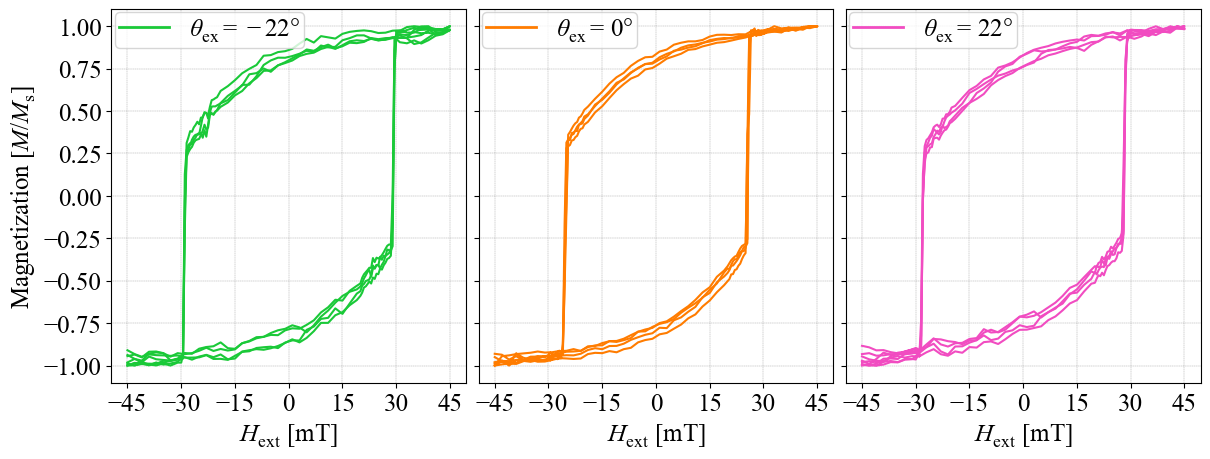

In [290]:
# Plot hysteresis for one angle:
def get_hystx():
    a = np.arange(-45, 19.1, 2)
    b = np.arange(20, 30.1, 0.5)
    c = np.arange(31, 43.1, 2)
    abc = np.concatenate([a,b,c])
    return np.concatenate([abc, -abc, np.array([-45])])

palette_tab10 = sns.color_palette('bright', 10)  #'colorblind' 'tab10' 'bright'
palette_tab10 = sns.color_palette([palette_tab10[2], palette_tab10[1], palette_tab10[6]])
labels = [r"$\theta_\mathrm{ex}=\,-22\degree$", r"$\theta_\mathrm{ex}=\,0\degree$", r"$\theta_\mathrm{ex}=\,22\degree$"]

fig, axs = plt.subplots(1,3, sharey=True, figsize=[12,4.7])
fig.tight_layout(h_pad=0, w_pad=-0.75)
axs[0].set_ylabel('Magnetization [$M/M_\mathrm{s}$]')
axs[0].set_yticks(np.arange(-1.0,1.01,0.25))
handles = []

for i,run_num in enumerate([158,180,202]):
    info = get_info(date, case, run_num)
    image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info
    raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)

    intensity_array = []
    zeros = []
    for mask_corners in mask:
        images = corrected_image_array[:,mask_corners[2]:mask_corners[3], mask_corners[0]:mask_corners[1]]
        means = np.array([ndi.mean(i) for i in images])
        means_min, means_max = np.min(means), np.max(means)
        normalized = (2*means - means_max - means_min)/(means_min-means_max)
        intensity_array.append(normalized)
        zeros.append(np.where(np.diff(np.sign(normalized)))[0])

    hyst_x = get_hystx()
    for j,images in enumerate(intensity_array):
        if j==0:
            axs[i].plot(hyst_x, images, label=labels[i], color=palette_tab10[i])
        else:
            axs[i].plot(hyst_x, images, color=palette_tab10[i])
    
    axs[i].set_xticks(np.arange(-45,46,15))
    axs[i].grid(axis='both', color="grey", linestyle="--", linewidth="0.25")
    axs[i].set_xlabel('$H_\mathrm{ext}$ [mT]')
    leg = axs[i].legend(loc='upper left',  borderpad=0.15, bbox_to_anchor=(-0.025, 1.025))
    for legobj in leg.legend_handles:
        legobj.set_linewidth(2.0)

    for element in zeros:
        print(hyst_x[element])

plt.show()
fig.savefig('Plots\\Div\\6.7 hysteresis plot.pdf', bbox_inches='tight')
fig.savefig('Plots\\Div\\6.7 hysteresis plot.png', bbox_inches='tight', dpi=1000) #bbox_extra_artists=(leg,),

29.0
-29.0
25.5
-25.0
28.0
-27.5


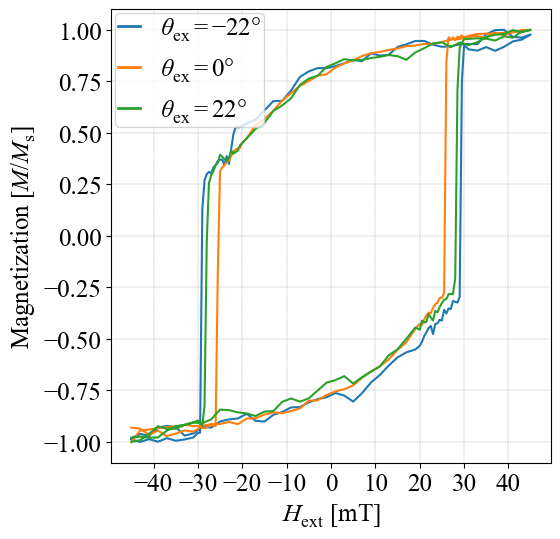

In [17]:
# Plot hysteresis for multiple angles:
  
def get_hystx():
    a = np.arange(-45, 19.1, 2)
    b = np.arange(20, 30.1, 0.5)
    c = np.arange(31, 43.1, 2)
    abc = np.concatenate([a,b,c])
    return np.concatenate([abc, -abc, np.array([-45])])

fig, axs = plt.subplots(figsize=[5.5,5.5])
fig.tight_layout(h_pad=0, w_pad=0)
axs.set_xticks(np.arange(-40,41,10))
axs.grid(axis='both', color="grey", linestyle="--", linewidth="0.25")
axs.set_xlabel('$H_\mathrm{ext}$ [mT]')
axs.set_ylabel('Magnetization [$M/M_\mathrm{s}$]')

hyst_x = get_hystx()
mask_idx = 2


for run_num in [158,180,202]:
    info = get_info(date, case, run_num)
    image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info
    if not os.path.exists(plot_path) and save_bool:
        os.makedirs(plot_path)
    raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)
    mask = mask[mask_idx]

    images = corrected_image_array[:,mask[2]:mask[3], mask[0]:mask[1]]
    means = np.array([ndi.mean(i) for i in images])
    means_min, means_max = np.min(means), np.max(means)
    intensity_array = (2*means - means_max - means_min)/(means_min-means_max)
    zeros = np.where(np.diff(np.sign(intensity_array)))[0]
    if run_num-180<0:
        add = "$-$"
    else:
        add = ""
    axs.plot(hyst_x, intensity_array, label = r"$\theta_\mathrm{ex}=$"+add+f"{abs(run_num-180)}$\degree$") # c= colors["b"]
    for element in zeros:
        print(hyst_x[element])
leg = plt.legend(loc='upper left', bbox_to_anchor=(-0.02, 1.02), markerscale=2.0, borderpad=0.1, handlelength=0.9) #linewidth=1
for legobj in leg.legend_handles:
    legobj.set_linewidth(2.0)
plt.show()
fig.savefig('Plots\\Div\\6.7 hysteresis plot BL.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
fig.savefig('Plots\\Div\\6.7 hysteresis plot BL.png', bbox_extra_artists=(leg,), bbox_inches='tight', dpi=1000)

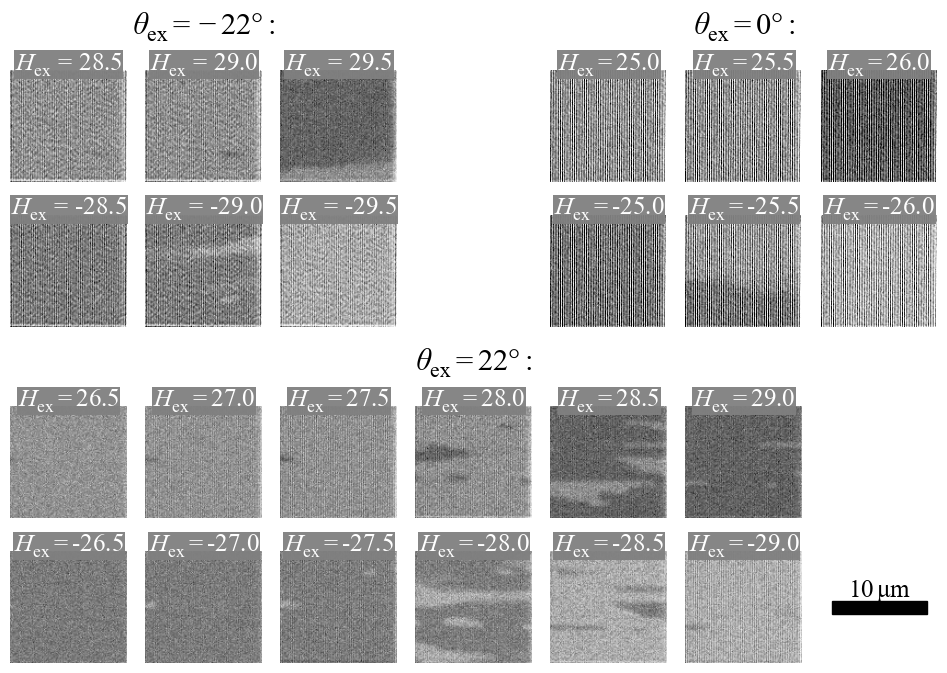

In [287]:
# Plot hyst images:
def get_hystx():
    a = np.arange(-45, 19.1, 2)
    b = np.arange(20, 30.1, 0.5)
    c = np.arange(31, 43.1, 2)
    abc = np.concatenate([a,b,c])
    return np.concatenate([abc, -abc, np.array([-45])])

fig, axs = plt.subplots(5,7, figsize=[10,7], height_ratios=[5,5,1,5,5])

axs = axs.flatten()
for ax in axs:
    ax.set_axis_off() 

palette_tab10 = sns.color_palette('bright', 10)  #'colorblind' 'tab10' 'bright'
palette_tab10 = sns.color_palette([palette_tab10[2], palette_tab10[1], palette_tab10[6]])
labels = [r"$\theta_\mathrm{ex}=-22\degree$", r"$\theta_\mathrm{ex}=0\degree$", r"$\theta_\mathrm{ex}=22\degree$"]
hyst_x = get_hystx()

run_num = 158
info = get_info(date, case, run_num)
image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info
raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)
image_array = corrected_image_array[:,mask[2][2]:mask[2][3], mask[2][0]:mask[2][1]]
h,w = image_array[0].shape
vmin, vmax = -0.3, 0.25
for i,idx in enumerate([50,51,52,111,112,113]):
    axs_idx = [0,1,2,7,8,9][i]
    axs[axs_idx].imshow(image_array[idx], cmap='Greys_r', vmin=vmin, vmax=vmax)
    axs[axs_idx].text(w/2,-5,"$H_\mathrm{ex}\,=\,$"+str(hyst_x[idx]), color="w", bbox=dict(facecolor='gray', edgecolor='none', pad=0.5, alpha= 0.95), ha='center', va='center') 
axs[1].text(w/2,-40,r"$\theta_\mathrm{ex}=-22\degree:$", color="black", ha='center', va='center', fontsize=22) 

run_num = 180
info = get_info(date, case, run_num)
image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info
raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)
image_array = corrected_image_array[:,mask[2][2]:mask[2][3], mask[2][0]:mask[2][1]]
h,w = image_array[0].shape
vmin, vmax = -0.25, 0.2
for i,idx in enumerate([43,44,45,104,105,106]):
    axs_idx = [4,5,6,11,12,13][i]
    axs[axs_idx].imshow(image_array[idx], cmap='Greys_r', vmin=vmin, vmax=vmax) 
    axs[axs_idx].text(w/2,-5,"$H_\mathrm{ex}=$"+str(hyst_x[idx]), color="w", bbox=dict(facecolor='gray', edgecolor='none', pad=0.5, alpha= 0.95), ha='center', va='center') 
axs[5].text(w/2,-40,r"$\theta_\mathrm{ex}=0\degree:$", color="black", ha='center', va='center', fontsize=22) 

run_num = 202
info = get_info(date, case, run_num)
image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info
raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)
image_array = corrected_image_array[:,mask[2][2]:mask[2][3], mask[2][0]:mask[2][1]]
h,w = image_array[0].shape
vmin, vmax = -0.3, 0.25
for i,idx in enumerate([46,47,48,49,50,51,107,108,109,110,111,112]):
    axs_idx = [21,22,23,24,25,26,28,29,30,31,32,33][i]
    axs[axs_idx].imshow(image_array[idx], cmap='Greys_r', vmin=vmin, vmax=vmax)
    axs[axs_idx].text(w/2,-5,"$H_\mathrm{ex}=$"+str(hyst_x[idx]), color="w", bbox=dict(facecolor='gray', edgecolor='none', pad=0.5, alpha= 0.95), ha='center', va='center') 
axs[24].text(w/2,-40,r"$\theta_\mathrm{ex}=22\degree:$", color="black", ha='center', va='center', fontsize=22) 

axs[34].imshow(np.zeros((h,w), dtype=np.float16), cmap='Greys')
axs[34].text(w/2,h/2.8, "$10\,\mathrm{\mu m}$", c = "black", ha='center', va='center') 
axs[34].add_patch(Rectangle(((w-87)/2, (h-12)/2), 87, 12, edgecolor="black", facecolor="black"))    

fig.tight_layout(h_pad=-0.8, w_pad=-0.5)
plt.show()
fig.savefig('Plots\\Div\\6.7 hyst images BL.png', bbox_inches='tight', dpi=800)

In [282]:
# Show images multi:
if not os.path.exists(multi_plot_path) and save_bool:
    os.makedirs(multi_plot_path)
image_array_list = []
for date_local in cases_runs_dict:
    for case_local in cases_runs_dict[date_local]:
        for run_num_local in cases_runs_dict[date_local][case_local]:
            info = get_info(date_local, case_local, run_num_local)
            image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info
            raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)
            # i = 0; joined_image_array = corrected_image_array[image_idx, mask[i][2]:mask[i][3], mask[i][0]:mask[i][1]]
            
            #joined_image_array = crop_and_join_images(corrected_image_array[image_idx], mask)
            joined_image_array = crop_and_join_images_mod(corrected_image_array[image_idx], mask)
            image_array_list.append(joined_image_array)
half = True
show_image_dist_multi(image_array_array=np.array(image_array_list), image_idx=image_idx, plot_path=multi_plot_path, extra_path = extra_path, save_bool = save_bool, half=half)
# show_image_dist_multi_mod1(image_array_array=np.array(image_array_list), image_idx=image_idx, plot_path=multi_plot_path, extra_path = extra_path, save_bool = save_bool)
      
# show_image_compare_multi(image_array_list=image_array_list, image_idx=image_idx, names=names, plot_path=multi_plot_path, extra_path = extra_path, save_bool = save_bool)


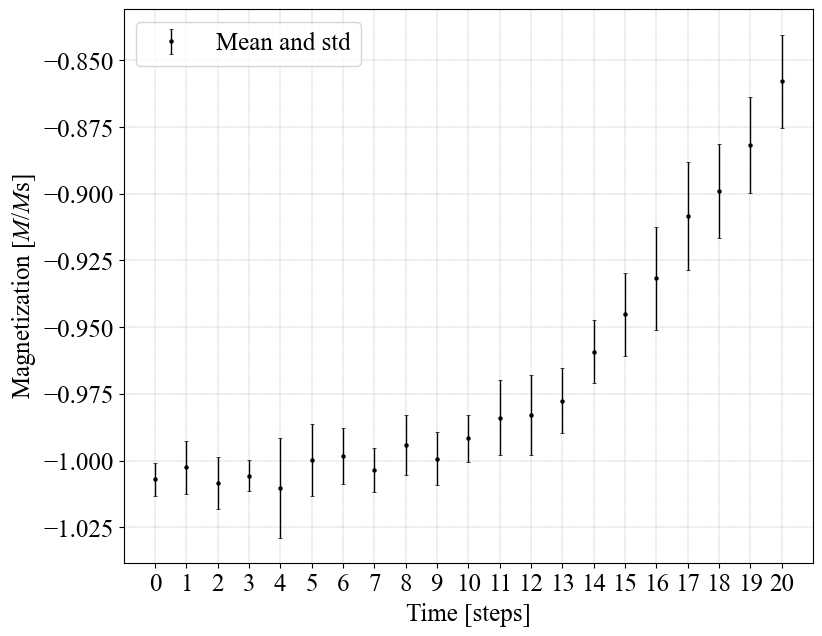

In [246]:
# Plot multi:
if not os.path.exists(multi_plot_path) and save_bool:
    os.makedirs(multi_plot_path)
intensity_array_list = []
for date_local in cases_runs_dict:
    for case_local in cases_runs_dict[date_local]:
        for run_num_local in cases_runs_dict[date_local][case_local]:
            info = get_info(date_local, case_local, run_num_local)
            image_folder_path, data_path, plot_path, mask, gif_interval, remove_idx_list, correction_xyd, rows, cols, plot_dict, annotate = info
            #raw_image_array, corrected_image_array = get_images(image_folder_path, remove_idx_list, correction_xyd)
            raw_image_array, corrected_image_array = get_images(image_folder_path, [], correction_xyd)
            
            if case_local == "7.3":
                pad = 8
            else:
                pad = 2
            i = 2; joined_image_array = corrected_image_array[:, mask[i][2]+pad:mask[i][3]-pad, mask[i][0]+pad:mask[i][1]-pad]
            # for j in image_idx:
            #     plt.imshow(joined_image_array[j], cmap='Greys_r')
            #     plt.show()
            intensity_array = np.array([ndi.mean(i) for i in joined_image_array])
            #val_min, val_max = np.max(intensity_array), intensity_array[1]
            val_min, val_max = intensity_array[0], intensity_array[1]
            # print(val_min, val_max)
            # print(intensity_array)
            intensity_array = (2*intensity_array[2:] - val_min - val_max)/(val_max-val_min)
            intensity_array_list.append(intensity_array)
            

#From new:
fig, axs = plt.subplots(figsize=[8,6.5])
fig.tight_layout(h_pad=0, w_pad=0)
axs.set_xticks(np.arange(0,intensity_array_list[0].shape[0],1)) #1,2
axs.grid(axis='both', color="grey", linestyle="--", linewidth="0.25")

palette_tab10 = sns.color_palette('colorblind', 10)  #'colorblind', bright
colors = {"b":palette_tab10[0],"brown":palette_tab10[5], "i":palette_tab10[9], "r":palette_tab10[3], "black": 'black', "g":palette_tab10[2], "purple":palette_tab10[4], "gray":palette_tab10[7], "y":palette_tab10[8], "p":palette_tab10[6], "o":palette_tab10[1]}           
keys = [key for key in colors]
markers = ["s", "D", "P", "X", "*", "o", "v", "^", "<", ">"]

if False:
    for i in range(len(intensity_array_list)):
        t = np.arange(intensity_array_list[i].shape[0])
        axs.plot(t, intensity_array_list[i], label = "Run "+str(i), color=colors[keys[i]], marker=markers[i], alpha=0.6)  # s=9
        name = ""
    leg = axs.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
else:
    t = np.arange(intensity_array_list[0].shape[0])
    mean = np.mean(intensity_array_list, axis=0)
    std = np.std(intensity_array_list, axis=0)
    plt.errorbar(t, mean, std, fmt="o", c="black", ms=2.2, elinewidth=1, label="Mean and std", capsize=1.5, capthick=0.5)
    name = "_mean"
    leg = axs.legend(loc='upper left')

#axs.set_ylim(-1.1,1.1)
axs.set_xlabel('Time [steps]')
axs.set_ylabel('Magnetization [$M/M\mathrm{s}$]')

plt.show()
fig.savefig(f'Plots\\Div\\{case_local} BL repeat_plot{name}.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
fig.savefig(f'Plots\\Div\\{case_local} BL repeat_plot{name}.png', bbox_extra_artists=(leg,), bbox_inches='tight', dpi=600)





In [ ]:
# Plot intensity multiple:
data_path_list = []
for key in cases_runs_dict:
    for element in cases_runs_dict[key]:
        info = get_info(key,run_path+str(element))
        image_folder_path, data_path, plot_path, hysteresis_txt, gif_interval, mask_remove_idx_list, norm_xyd, rows, cols, plot_dict, annotate = info
        if gen_data:
            generate_data(image_folder_path=image_folder_path, hysteresis_txt=hysteresis_txt, data_path=data_path, mask_remove_idx_list=mask_remove_idx_list, norm_xyd=norm_xyd)
        data_path_list.append(data_path)

if not os.path.exists(multi_plot_path) and save_bool:
    os.makedirs(multi_plot_path)
plot_intensity_multi(data_path_list=data_path_list, plot_dict=plot_dict, plot_path=multi_plot_path, extra_path=extra_path, save_bool=save_bool)
plot_hysteresis_multi(data_path_list=data_path_list, plot_dict=plot_dict, hyst_names=hyst_names, plot_path=multi_plot_path, extra_path=extra_path, save_bool=save_bool)


In [ ]:
# Div
info = get_info(case,run_path+str(run_num))
image_folder_path, data_path, plot_path, hysteresis_txt, gif_interval, mask_remove_idx_list, norm_xyd, rows, cols, plot_dict, annotate = info
# if not os.path.exists(plot_path) and save_bool:
#     os.makedirs(plot_path)
raw_image_array, norm_image_array, cropped_norm_image_array, bounds, norm_0 = get_images(image_folder_path=image_folder_path, mask_remove_idx_list=mask_remove_idx_list, norm_xyd=norm_xyd)
plot_pixel_hist(cropped_norm_image_array, norm_0, plot_dict)
    

#compare_shift()


# palette_tab10 = sns.color_palette("colorblind", 10)
# plt.rcParams['axes.prop_cycle'] = cycler(color=palette_tab10)
# for i in range(10):
#     t = np.arange(30)
#     y = np.arange(30)/5
#     plt.plot(t,y+i*3)
# plt.show()

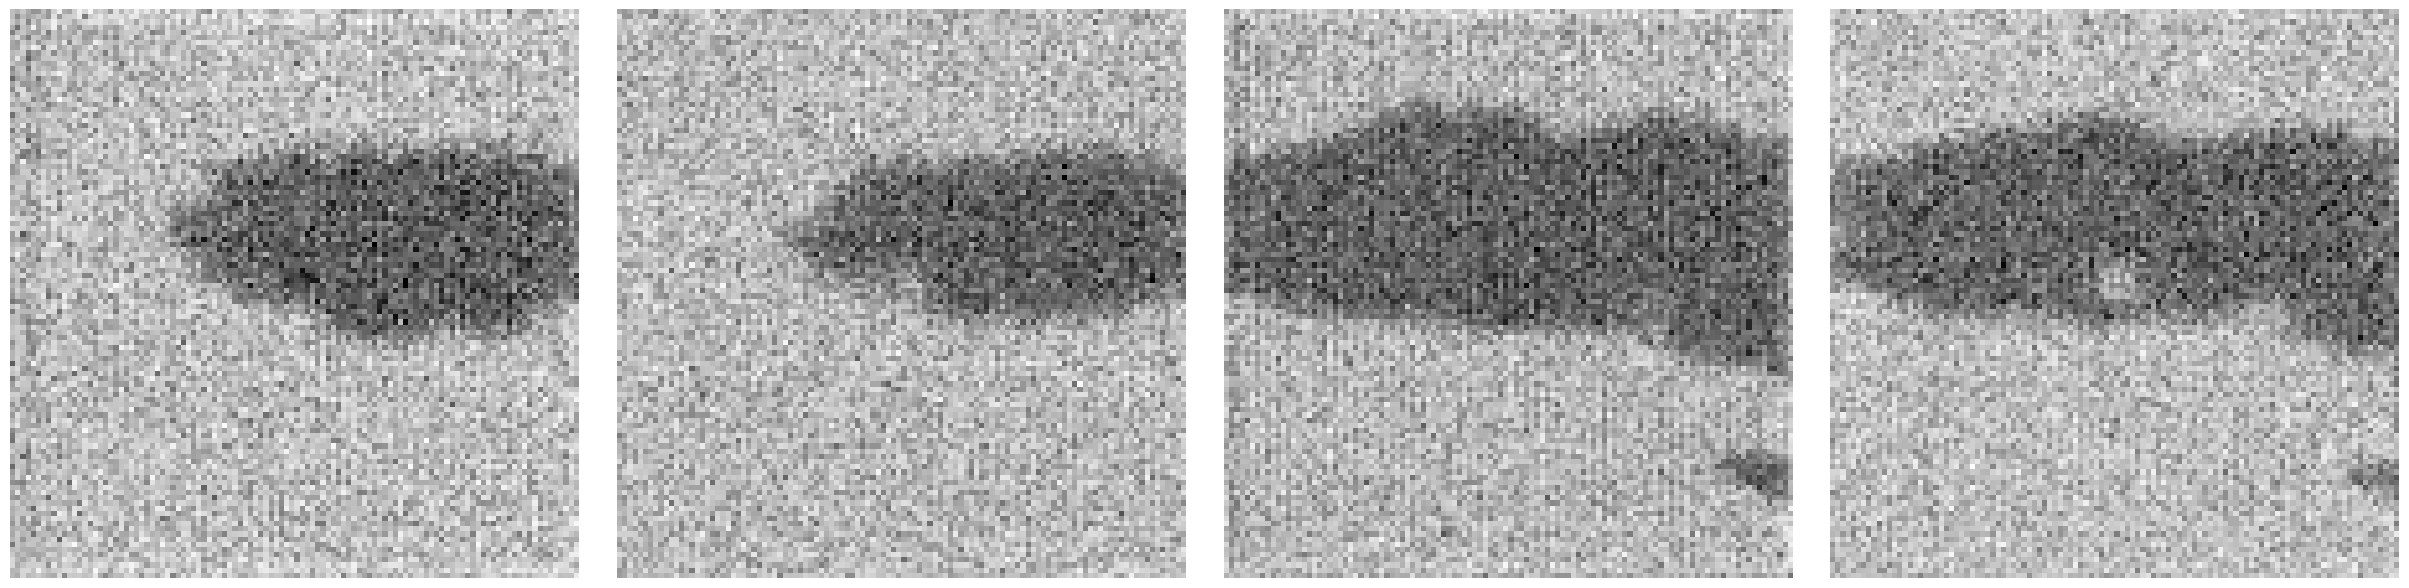

In [19]:

fig, axs = plt.subplots(1,4,figsize=[25, 10]) 
fig.tight_layout(h_pad=0, w_pad=-0.75)
axs = axs.flatten()
for ax in axs:
    ax.set_axis_off() 
path = "C:/Users/eivhe/OneDrive/NTNU/Prosjekt- og masteroppgave/Measurements/24.04.04_IB2403.1/7.8/Run 5/"
correction_xyd = [410,40,100]

image = img.imread(path+"Image_0024.png")
image -= ndi.mean(image[correction_xyd[1]:correction_xyd[1]+correction_xyd[2],correction_xyd[0]:correction_xyd[0]+correction_xyd[2]])
axs[0].imshow(image[150:260, 227:337], cmap="Greys_r")
axs[2].imshow(image[345:455, 227:337], cmap="Greys_r")

image = img.imread(path+"Image_0025.png")
image -= ndi.mean(image[correction_xyd[1]:correction_xyd[1]+correction_xyd[2],correction_xyd[0]:correction_xyd[0]+correction_xyd[2]])
axs[1].imshow(image[150:260, 227:337], cmap="Greys_r")
axs[3].imshow(image[345:455, 227:337], cmap="Greys_r")

fig.savefig('Plots\\Div\\Donut.png', bbox_inches='tight', dpi=1000)
plt.show()